In [87]:
%matplotlib widget

from sklearn.datasets import load_iris
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

In [88]:
# load the full dataset and display it
dataset = load_iris()
names = dataset.feature_names
data = dataset.data
target = dataset.target

print(names)
print(data.dtype, data)
print(target.dtype, target)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
float64 [[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]
 [5.4 3.7 1.5 0.2]
 [4.8 3.4 1.6 0.2]
 [4.8 3.  1.4 0.1]
 [4.3 3.  1.1 0.1]
 [5.8 4.  1.2 0.2]
 [5.7 4.4 1.5 0.4]
 [5.4 3.9 1.3 0.4]
 [5.1 3.5 1.4 0.3]
 [5.7 3.8 1.7 0.3]
 [5.1 3.8 1.5 0.3]
 [5.4 3.4 1.7 0.2]
 [5.1 3.7 1.5 0.4]
 [4.6 3.6 1.  0.2]
 [5.1 3.3 1.7 0.5]
 [4.8 3.4 1.9 0.2]
 [5.  3.  1.6 0.2]
 [5.  3.4 1.6 0.4]
 [5.2 3.5 1.5 0.2]
 [5.2 3.4 1.4 0.2]
 [4.7 3.2 1.6 0.2]
 [4.8 3.1 1.6 0.2]
 [5.4 3.4 1.5 0.4]
 [5.2 4.1 1.5 0.1]
 [5.5 4.2 1.4 0.2]
 [4.9 3.1 1.5 0.2]
 [5.  3.2 1.2 0.2]
 [5.5 3.5 1.3 0.2]
 [4.9 3.6 1.4 0.1]
 [4.4 3.  1.3 0.2]
 [5.1 3.4 1.5 0.2]
 [5.  3.5 1.3 0.3]
 [4.5 2.3 1.3 0.3]
 [4.4 3.2 1.3 0.2]
 [5.  3.5 1.6 0.6]
 [5.1 3.8 1.9 0.4]
 [4.8 3.  1.4 0.3]
 [5.1 3.8 1.6 0.2]
 [4.6 3.2 1.4 0.

In [89]:
# preprocess the data to remove the third category so we have binary classification for now
index = np.searchsorted(target, 2)

data = data[:index]
target = target[:index].astype(np.float64) # convert to float64

print(names)
print("Data: ", data.shape, data.dtype)
print("Target:", target.shape, target.dtype)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Data:  (100, 4) float64
Target: (100,) float64


We've seen how classification with feature engineering a linear model doesn't work as the sigmoid function isn't controllable by the model weights. Therefore, the goal here is to do logistic regression using a sigmoid function instead. We will have to derive the new cost and gradient function. However, we take a small detour than traditional logistic regression. For the new cost function, we will still use mean squared error (MSE) so the cost function stays the same except the sigmoid is added for the prediction. The new prediction will be a sigmoid prediction and new gradients will be based on the classic MSE cost function. This will hopefully produce some interesting results. This is also the first approach anyone would take.

In [90]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [91]:
def predict(w,b,x):
    prediction = np.matmul(x, w) + b
    
    return sigmoid(prediction) # pass it through a sigmoid

In [92]:
def mse_cost(w,b,x,y):
    m = x.shape[0] # number of training examples
    n = x.shape[1] # number of features
    
    prediction = sigmoid(np.matmul(x, w) + b) # pass it through a sigmoid
    error = prediction - y
    error = error.reshape((-1)) # make it m (1d array) from mx1
    
    return np.dot(error, error) / (2*m)

In [93]:
def compute_gradient(w,b,x,y):
    m = x.shape[0] # number of training examples
    n = x.shape[1] # number of features

    prediction = sigmoid(np.matmul(x, w) + b) # mx1
    predictionT = np.transpose(prediction) # 1xm

    error = (prediction - y) * prediction * (1 - prediction) # mx1

    xT = np.transpose(x) # nxm
    dw = np.matmul(xT, error) / m # nx1
    db = np.matmul(predictionT, (prediction - y) * (1 - prediction))[0,0] / m # 1

    return dw, db

The new cost and gradient functions now change to accomodate the sigmoid we use use as the original function to classify the dataset. For the cost, it's simply piping the linear model to the sigmoid but for the gradient it's more complex since the derivative changes as well. But deriving this new derivative can be massively simplified if you think about the sigmoid function as a function with the linear model and use the chain rule. 

In [94]:
def feature_scale(data_unscaled, scaled=True):
    if scaled == False:
        return data_unscaled

    mu = np.mean(data_unscaled, axis=0)
    std = np.std(data_unscaled, axis=0)

    data_scaled = np.array(data_unscaled)
    data_scaled = (data_scaled - mu) / std
    # z score normalization
    
    return data_scaled

data = feature_scale(data, scaled=True)

In [95]:
def show_cost_graph(costs, title):
    iterations = costs.shape[0]
    iteration_array = np.arange(0, iterations, dtype=np.int32)
    
    # graph the cost after updating the model
    fig, cost_graph = plt.subplots(layout='constrained')
    
    cost_graph.set_xlabel("Current Iteration")
    cost_graph.set_ylabel("Cost")
    
    cost_graph.set_title(title)
    
    cost_graph.plot(iteration_array, costs, color="r")

w: [[ 0.94578415]
 [-1.41441356]
 [ 1.86630906]
 [ 1.89674408]]
b: 0.20993369204711235
final cost: 0.0001177677957287419


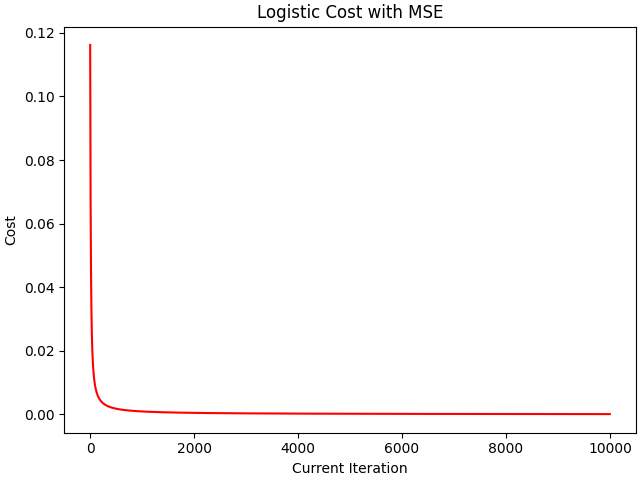

In [96]:
def gradient_descent(x, y, learning_rate=0.01, max_iterations=1000):
    y = y.reshape((-1,1))
    m = x.shape[0] # number of training examples
    n = x.shape[1] # number of features
    
    w = np.zeros((n,1)) # n features
    b = 0
    # initialize model parameters to zeroes
    
    costs = np.empty(0)

    for i in range(max_iterations):
        dw, db = compute_gradient(w,b,x,y)
        
        w -= learning_rate * dw
        b -= learning_rate * db
        # update the weights
        
        current_cost = mse_cost(w,b,x,y)
        costs = np.append(costs, current_cost)
        # add to array for visualization

    print("w:",w)
    print("b:",b)
    print("final cost:",costs[-1])
    return w, b, costs
weights, intercept, standard_costs = gradient_descent(data, target, learning_rate=0.2, max_iterations=10000)
show_cost_graph(standard_costs, title="Logistic Cost with MSE")

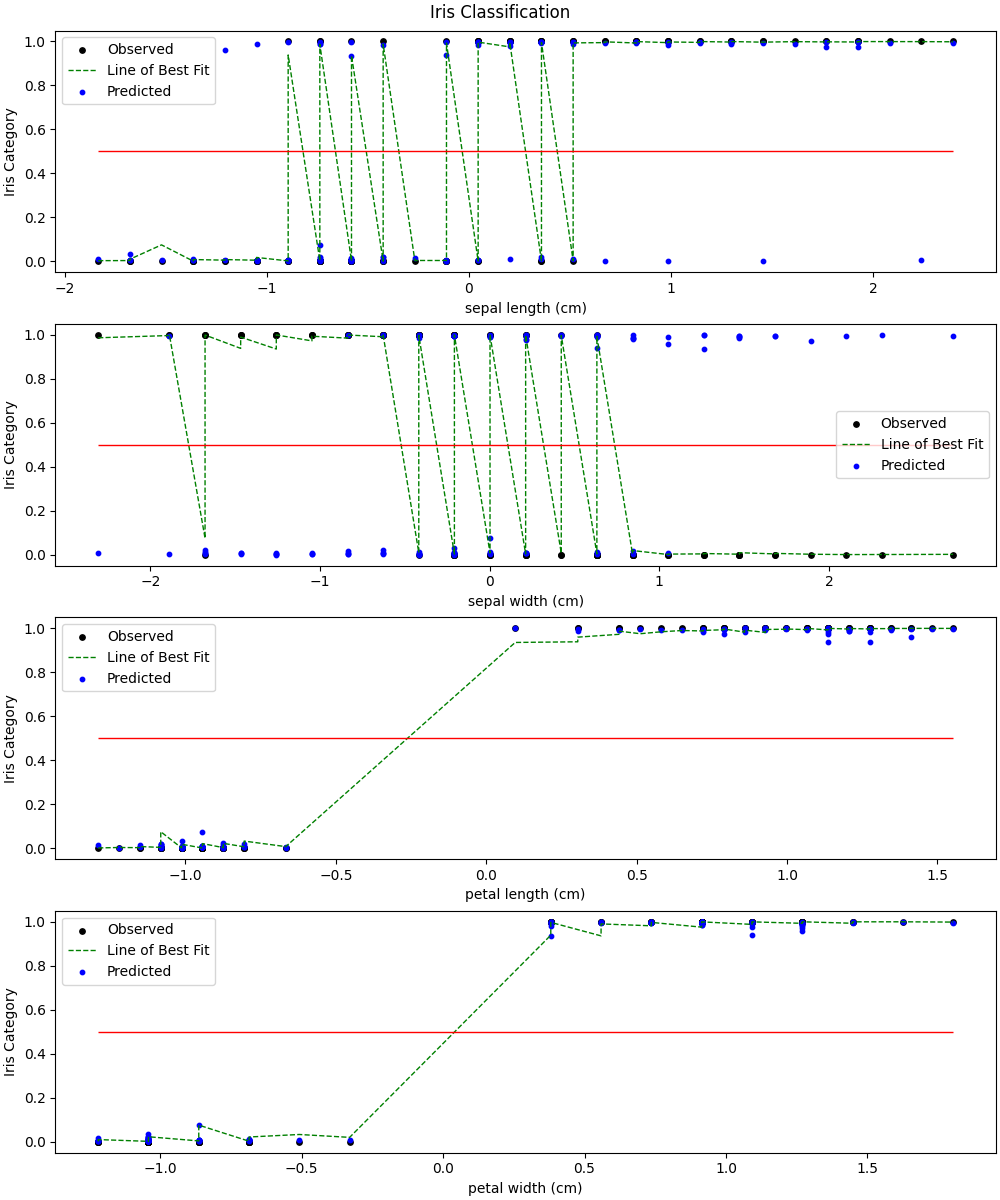

In [97]:
hypothesis = predict(weights, intercept, data).reshape(-1)
features = data.shape[1]

fig, axes = plt.subplots(features, layout="constrained",figsize=(10,12))
fig.suptitle("Iris Classification")
for i in range(features):
    axes[i].set_xlabel(names[i])
    axes[i].set_ylabel("Iris Category")

    idata, ipredict = zip(*sorted(zip(data[:,i], hypothesis))) # sort the x and y values and retrieve them
    
    axes[i].scatter(data[:,i], target, c="black",s=15,label="Observed")
    axes[i].plot(idata, ipredict, c="g", linewidth=1, linestyle='--',label="Line of Best Fit")
    axes[i].scatter(data[:,i], ipredict, c="blue",s=10,label="Predicted")
    axes[i].hlines(y=0.5, xmin=np.min(data[:,i]), xmax=np.max(data[:,i]), linewidth=1, color='r')
    axes[i].legend()

In [98]:
classify = np.round(hypothesis)
errors = np.sum(np.abs(classify - target))
print("Misclassifications:",errors)

Misclassifications: 0.0


Here we got lucky and got no misclassifications. Let's visualize how different intercept values affect the cost function. We'll fix all the other values and only change one of the values (intercept) with a range. This helps us visualize easier as well.

In [99]:
samples = 200
frange = 40
brange = np.linspace(-frange, frange, samples)

y_reshaped = target.reshape((-1,1))
bcosts = np.empty(samples)
for i in range(samples):
    bcosts[i] = mse_cost(weights,brange[i],data,y_reshaped)

Text(0, 0.5, 'Cost')

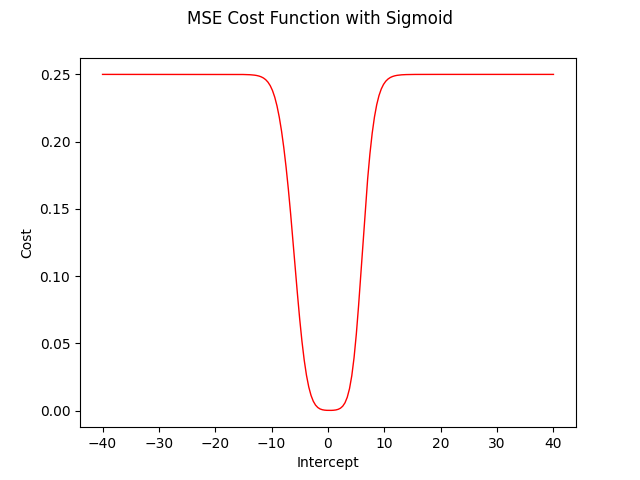

In [100]:
fig, ax = plt.subplots()
fig.suptitle("MSE Cost Function with Sigmoid")
ax.plot(brange, bcosts, c='r',linewidth=1)
ax.set_xlabel("Intercept")
ax.set_ylabel("Cost")

Wait this is really weird. Cost function looks great in the center but as we veer off far, then it basically becomes a line. Let's look closer at the edges and see if it still decreases.

In [101]:
samples = 200
brange = np.linspace(50, 60, samples)

y_reshaped = target.reshape((-1,1))
bcosts = np.empty(samples)
for i in range(samples):
    bcosts[i] = mse_cost(weights,brange[i],data,y_reshaped)

Text(0, 0.5, 'Cost')

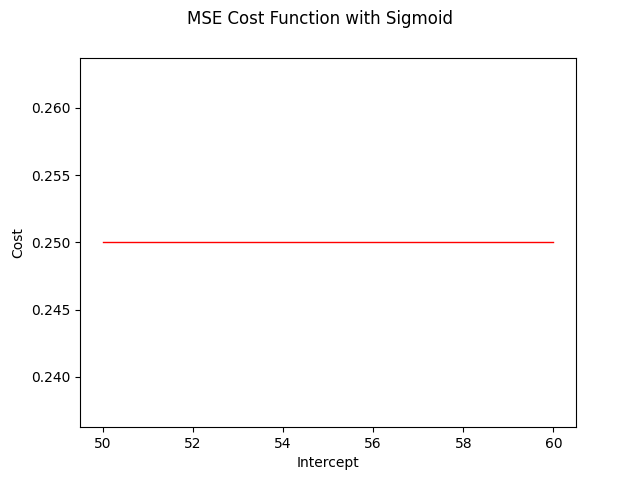

In [102]:
fig, ax = plt.subplots()
fig.suptitle("MSE Cost Function with Sigmoid")
ax.plot(brange, bcosts, c='r',linewidth=1)
ax.set_xlabel("Intercept")
ax.set_ylabel("Cost")

As we suspected, this is really bad. The cost doesn't decrease or barely decrease if it decreases at all. This cost is bad and will cause problems for different values of b. This is clearly bad as we want a nice parabola function. Next, let's look at all of the weights individually and see if we see a different pattern emerge. As before, we will fixate all of the weights and intercept and only change one weight at a time.

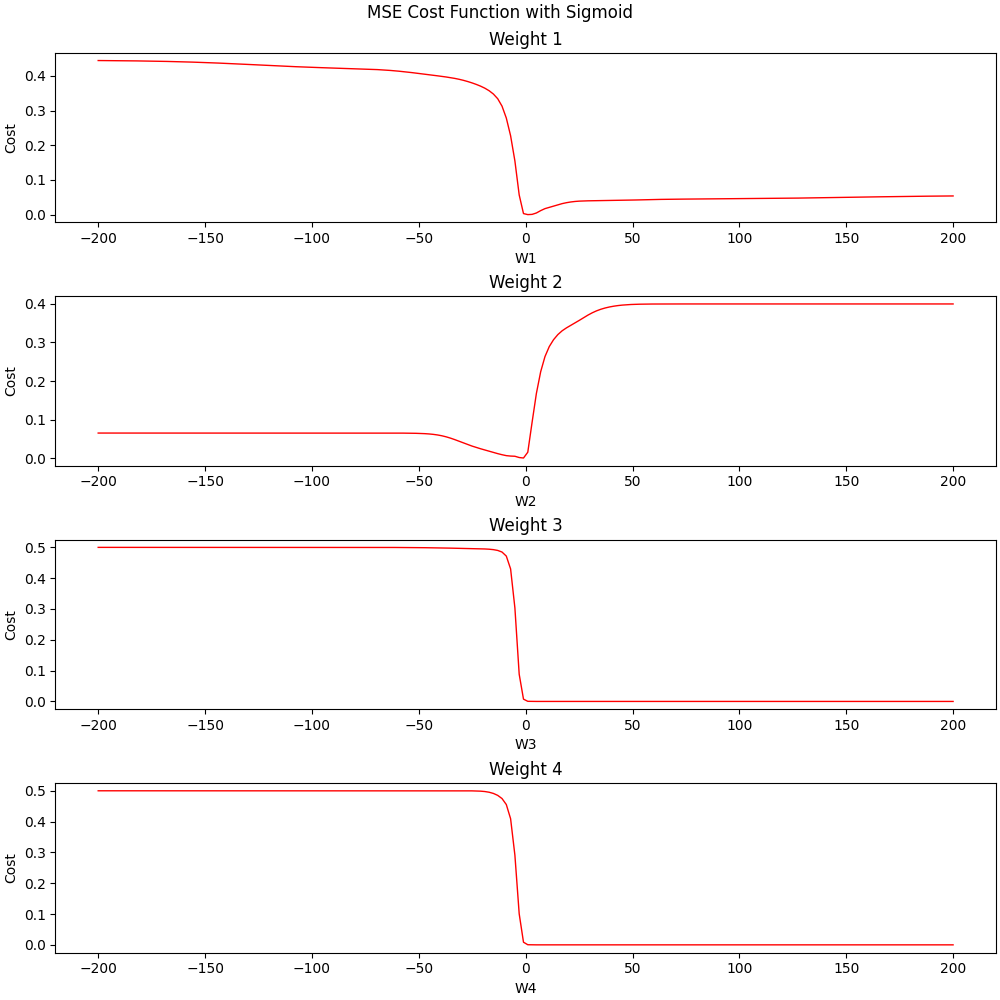

In [103]:
y_reshaped = target.reshape((-1,1))
samples = 200
frange = 200

fig, axes = plt.subplots(features,figsize=(10,10),layout="constrained")
fig.suptitle("MSE Cost Function with Sigmoid")

for j in range(features):
    wrange = np.linspace(-frange, frange, samples)

    wjcosts = np.empty(samples)
    for i in range(samples):
        weights_i = np.array(weights) # use weights we got from gradient descent
        weights_i[j,0] = wrange[i] # change jth feature weight and fix all other weights
        wjcosts[i] = mse_cost(weights_i,intercept,data,y_reshaped)

    axes[j].set_xlabel(f"W{j+1}")
    axes[j].set_ylabel("Cost")
    axes[j].set_title(f"Weight {j+1}")
    axes[j].plot(wrange, wjcosts, c='r',linewidth=1)

Wow, none of these costs look right at all. It's looks like even if these costs are decreasing, it would take forever to train them. This is already a major problem in itself. Additionally, if you look hard enough on Weight 1 between -200 and 0, it even looks increasing. This means we introduced local minima by deciding to use MSE on a sigmoid function. This shows us that everytime we have a new cost function, we have to make sure that the cost function doesn't have any local minima where we train our weights on. Otherwise, it will get stuck in these local minima and never reach the bottom (valley) of the cost function.

The next goal based on these observations is to use a different cost function that is much better and doesn't have local minima or slow decreasing problems. 